# Building a Multi-Agent System

In this notebook, we showcase how the toolkit can be used to use a mixture of inbuilt tools and agents, as well as custom tools and workflows.

We created a simple [mixture-of-agents](notebooks/examples/retail_sales_agent/) that serves as an assistant in retail sales. 
> **Note**: *This is just an example agent system that uses dummy data. The intention is to demonstrate some of the capabilities of this toolkit and how a new user can get familiar with it.* 

This agent system has:
1) A **supervisor** agent that routes incoming requests to the downstream agent expert
2) A **data insight** agent that is a tool-calling agent capable of answering questions about sales data
3) A **RAG agent** that is capable of answering questions about products using context from a product catalog
4) A **data visualization** agent that is capable of plotting graphs and trends

We demonstrate the following capabilities:
- RAG # To-do: add milvus
- Multi-framework support
- Human-in-the-Loop # To-do: fix bug
- Multi-agent support
- LTM # To-do

For more capabilities, refer to the `examples` directory.

> **Note**: 
> All source code for this example can be found at [notebooks/examples/retail_sales_agent/](notebooks/examples/retail_sales_agent/)

### Creating a New Workflow for this Agent

To recap, to create a new workflow for this mixture of agents, we need to use the `aiq create` sub-command which creates the necessary directory structure. 

> **Note**: You can create this directory structure manually as well.

All new functions (tools and agents) that you want to be a part of this agent system can be created inside this directory for easier grouping of plugins. The only necessity for discovery by the toolkit is to import all new files (or individual functions) in the `register.py` function.

In [ ]:
!aiq workflow create --workflow-dir .tmp/notebooks/examples retail_sales_agent

### Adding Tools

To start off simple, let's create a single agent that serves as a helpful assistant that can answer questions about the retail sales CSV data. It will call tools to fetch daily sales of a product, calculate total sales per day and detect any outliers in sales.

**Function Creation**: All tools are created in [data_insight_tools.py](notebooks/examples/retail_sales_agent/src/retail_sales_agent/data_insight_tools.py). They each have a configuration object and the registered function.

**Import the registered function**: Make sure to import the registered function in [register.py](notebooks/examples/retail_sales_agent/src/retail_sales_agent/register.py)

**Create the YAML file**: For simplicity, we use the in-built react agent in the workflow and define the tools that should be made available to the agent. We also set the LLM to use. You can find the config file at [config.yml](notebooks/examples/retail_sales_agent/configs/config.yml)

In [ ]:
!aiq run --config_file notebooks/examples/retail_sales_agent/configs/config.yml --input "How do laptop sales compare to phone sales?"

Some other test queries that can be run are:
- "What were the laptop sales on Feb 16th 2024?"
- "What were the outliers in sales?"

### Adding a RAG Agent using Llamaindex

In [3]:
df = pd.read_csv("notebooks/examples/retails_sales_agent/data/retail_sales_data.csv")

In [26]:
df.head()

,Date,StoreID,Product,UnitsSold,Revenue,Promotion
0,2024-01-01,S001,laptop,1,1000,No
1,2024-01-01,S001,phone,9,4500,No
2,2024-01-01,S001,tablet,2,600,No
3,2024-01-01,S002,laptop,9,9000,No
4,2024-01-01,S002,phone,10,5000,No


In [27]:
df["Date"].dtype

dtype('<M8[ns]')

In [6]:
result_df = df.groupby(['Product'])['Revenue'].sum().reset_index()

In [44]:
# Set the API key directly in the notebook (replace with your actual key)
import os
# Uncomment and set your API key:
# os.environ["NVIDIA_API_KEY"] = "your_actual_api_key_here"

# Or check if it's already set
api_key = os.getenv('NVIDIA_API_KEY')
print(f"API Key available: {bool(api_key)}")
if api_key:
    print(f"API Key starts with: {api_key[:8]}...")
else:
    print("⚠️  NVIDIA_API_KEY not found in environment variables")


API Key available: False
⚠️  NVIDIA_API_KEY not found in environment variables


In [7]:
result_df.head()

,Product,Revenue
0,Laptop,512000
1,Phone,561000
2,Tablet,212700


In [8]:
result_df.to_dict('records')

[{'Product': 'Laptop', 'Revenue': 512000},
 {'Product': 'Phone', 'Revenue': 561000},
 {'Product': 'Tablet', 'Revenue': 212700}]

In [14]:
product = "laptop"
df['Product'] = df["Product"].apply(lambda x: x.lower())
result_df = df[df['Product']== product]['UnitsSold'].sum()
result_df

512

In [16]:
result_df = df.groupby(['Date'])['Revenue'].sum().reset_index()

In [17]:
result_df

,Date,Revenue
0,2024-01-01,21600
1,2024-01-02,24300
2,2024-01-03,24400
3,2024-01-04,23300
4,2024-01-05,33500
5,2024-01-06,31000
6,2024-01-07,18400
7,2024-01-08,22700
8,2024-01-09,27800
9,2024-01-10,25300


In [21]:
len(df['Date'].unique())

50

In [24]:
df["Date"] = pd.to_datetime(df["Date"])

In [25]:
df["Date"] 

0     2024-01-01
1     2024-01-01
2     2024-01-01
3     2024-01-01
4     2024-01-01
         ...    
295   2024-02-19
296   2024-02-19
297   2024-02-19
298   2024-02-19
299   2024-02-19
Name: Date, Length: 300, dtype: datetime64[ns]

In [31]:
date = "2025-01-01"
df[df['Date'] == date]['Revenue'].sum()

0

In [29]:
df[df.groupby('Product')["Date"] == date]['Revenue'].sum().reset_index()

KeyError: False

In [30]:
df.groupby('Product')['Date"]

SyntaxError: unterminated string literal (detected at line 1) (3679307984.py, line 1)

In [32]:
df[df['Date'] == date & df['Product'] == product]['Revenue'].sum()

TypeError: Cannot perform 'rand_' with a dtyped [object] array and scalar of type [bool]

In [35]:
column = "Revenue"
q1 = df[column].quantile(0.25)
q3 = df[column].quantile(0.75)
iqr = q3 - q1
outliers = df[(df[column] < q1 - 1.5 * iqr) | (df[column] > q3 + 1.5 * iqr)]
outliers.to_dict('records')

[{'Date': Timestamp('2024-01-26 00:00:00'),
  'StoreID': 'S002',
  'Product': 'phone',
  'UnitsSold': 24,
  'Revenue': 12000,
  'Promotion': 'Yes'},
 {'Date': Timestamp('2024-02-15 00:00:00'),
  'StoreID': 'S001',
  'Product': 'phone',
  'UnitsSold': 26,
  'Revenue': 13000,
  'Promotion': 'Yes'}]

In [ ]:
df[(df['Date'] == "2024-02-16") & (df['Product'] == product)]['Revenue'].sum()

In [45]:
import getpass
import os

if "NVIDIA_API_KEY" not in os.environ:
    nvidia_api_key = getpass.getpass("Enter your NVIDIA API key: ")
    os.environ["NVIDIA_API_KEY"] = nvidia_api_key

In [57]:
import os
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader
from llama_index.core import Settings
from llama_index.core import SimpleDirectoryReader
from llama_index.core import VectorStoreIndex
from llama_index.llms.nvidia import NVIDIA
from llama_index.embeddings.nvidia import NVIDIAEmbedding
from llama_index.core.node_parser import SentenceSplitter



llm = NVIDIA(model="meta/llama-3.3-70b-instruct", api_key=os.getenv("NVIDIA_API_KEY"))
embedder = NVIDIAEmbedding(model="nvidia/nv-embedqa-e5-v5", api_key=os.getenv("NVIDIA_API_KEY"))

Settings.embed_model = embedder
Settings.llm = llm

# Load documents and build index
documents = SimpleDirectoryReader(
        input_files=["notebooks/examples/retails_sales_agent/data/rag/product_catalog.md"]
    ).load_data()
parser = SentenceSplitter(
        chunk_size=256,  # Larger chunks to preserve context but stay under 512 tokens
        chunk_overlap=20,  # Smaller overlap to reduce redundancy
        separator=" ",
    )
nodes = parser.get_nodes_from_documents(documents)
index = VectorStoreIndex(nodes)

query_engine = index.as_query_engine(
    similarity_top_k=1,  # Retrieve only the most relevant chunk
    response_mode="compact",  # Use compact response mode
)
response = query_engine.query("What is the TabZen S9 Ultra tablet and what are its specifications?")
print(response)

The TabZen S9 Ultra is a tablet that offers a range of features and capabilities. It supports an environment that allows for external display mirroring and full multitasking with overlapping windows and keyboard shortcuts. In terms of input capabilities, it comes with a stylus that features magnetic charging, 4096 pressure levels, and tilt detection, as well as haptic feedback to simulate traditional pen strokes and brush textures. The device also supports a keyboard with a trackpad and programmable shortcut keys. 

The tablet's camera hardware includes a 13MP main sensor and a 12MP ultra-wide front camera with center-stage tracking and biometric unlock. It also features microphone arrays with beamforming for studio-quality call audio. For connectivity, it includes Wi-Fi 7, Bluetooth 5.3, and optional LTE/5G with eSIM. The device runs on an operating system based on Android 14L, supporting app sandboxing, multi-user profiles, and remote device management.


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("notebooks/examples/retails_sales_agent/data/retail_sales_data.csv")


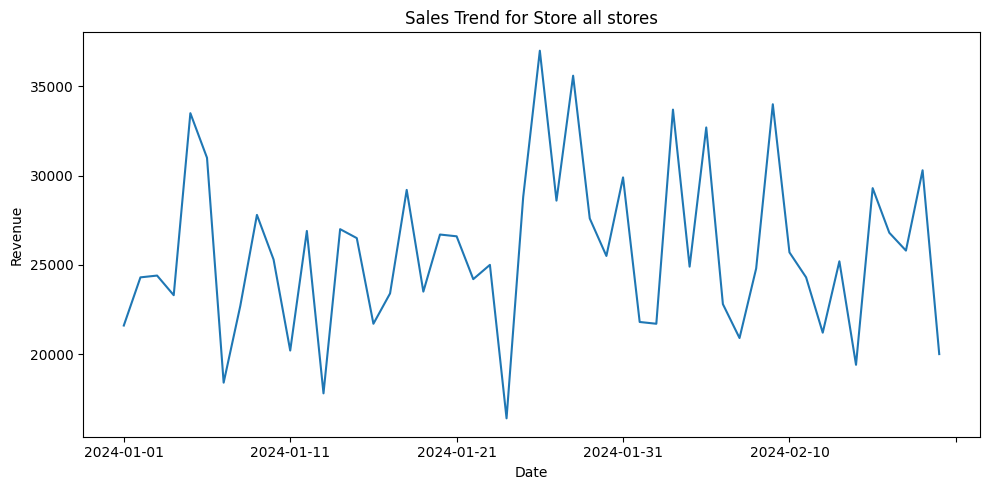

In [9]:
plt.figure(figsize=(10, 5))
# store = "S001"
# data = df[df["StoreID"] == store]
data = df
title = f"Sales Trend for Store all stores"
trend = data.groupby("Date")["Revenue"].sum()
trend.plot(title=title)
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.tight_layout()


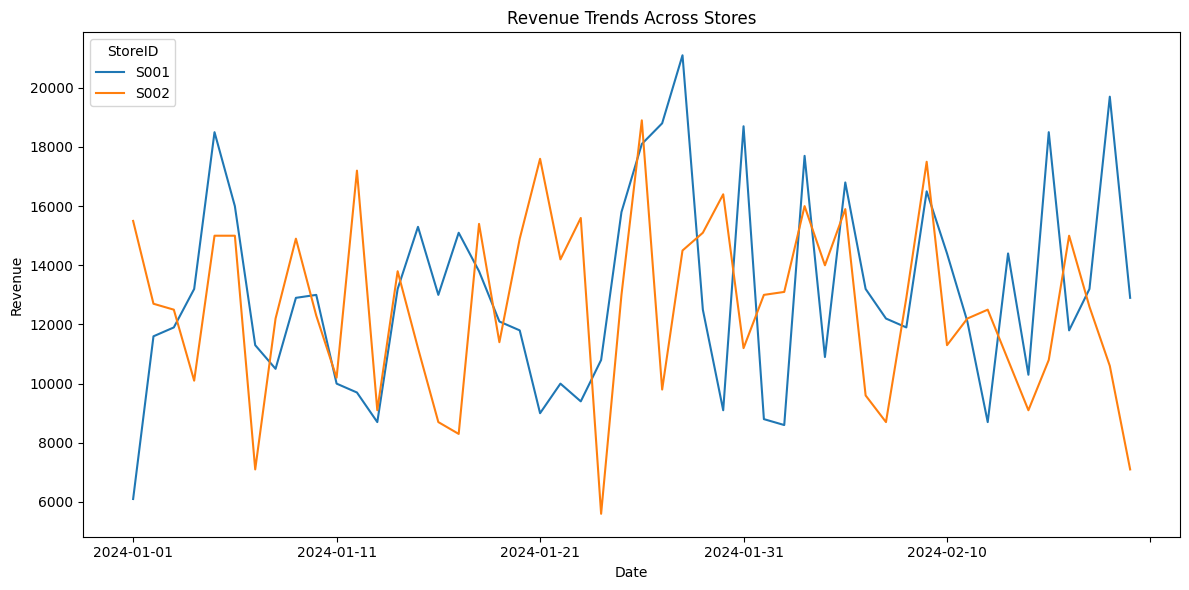

In [10]:
metric = "Revenue"
pivot = df.pivot_table(index="Date", columns="StoreID", values=f"{metric}", aggfunc="sum")
pivot.plot(figsize=(12, 6), title=f"{metric} Trends Across Stores")
plt.xlabel("Date")
plt.ylabel(f"{metric}")
plt.legend(title="StoreID")
plt.tight_layout()

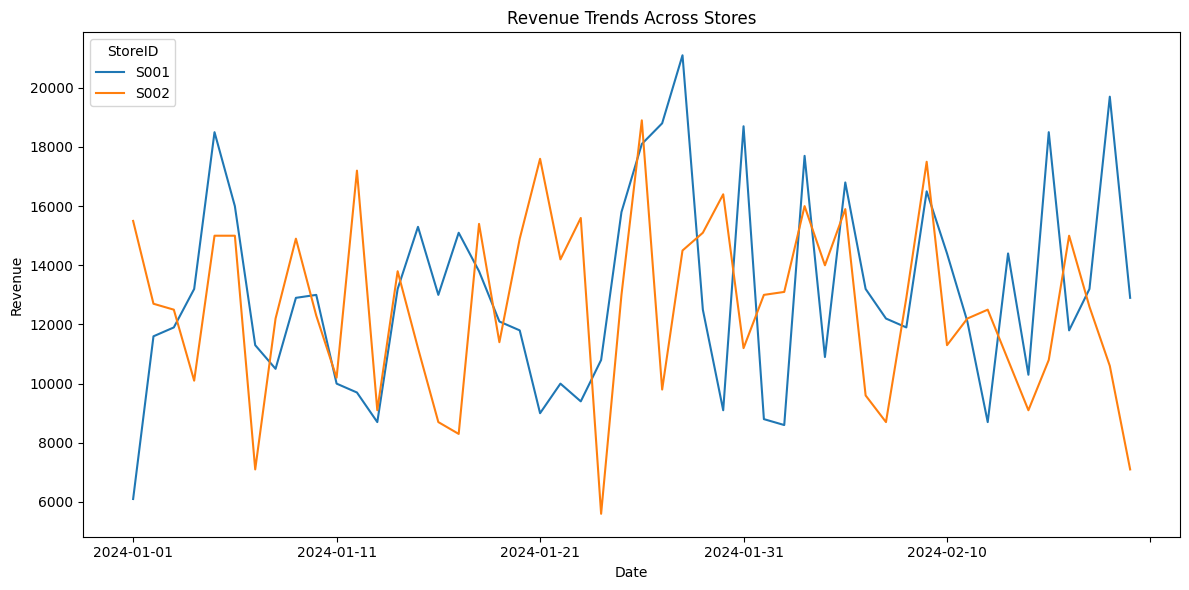

In [6]:
pivot = df.pivot_table(index="Date", columns="StoreID", values="Revenue", aggfunc="sum")
pivot.plot(figsize=(12, 6), title="Revenue Trends Across Stores")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend(title="StoreID")
plt.tight_layout()



NameError: name 'plt' is not defined

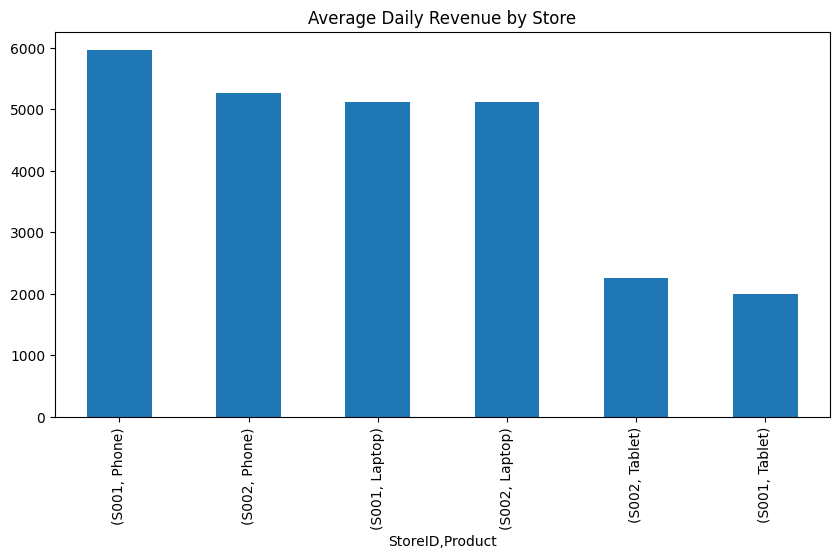

In [4]:
avg_sales = df.groupby(["StoreID", "Product"])["Revenue"].mean().sort_values(ascending=False)
avg_sales.plot(kind="bar", title="Average Daily Revenue by Store", figsize=(10, 5))
plt.ylabel("Average Revenue")
plt.tight_layout()

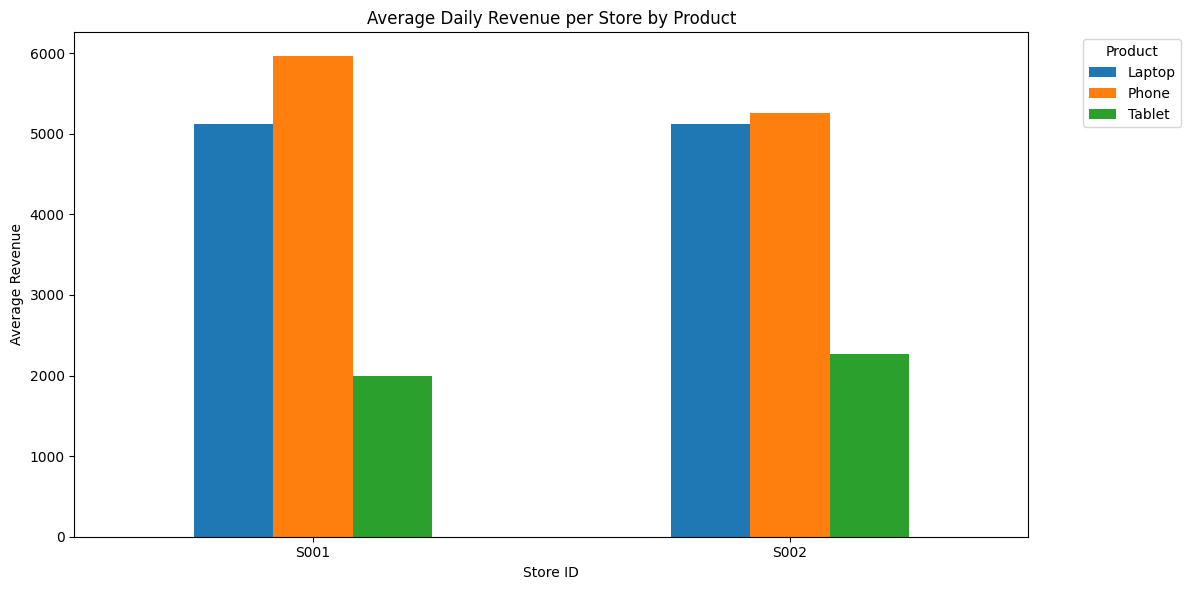

In [11]:
daily_revenue = df.groupby(["StoreID", "Product", "Date"])["Revenue"].sum().reset_index()

# Now compute average daily revenue for each StoreID and Product
avg_daily_revenue = daily_revenue.groupby(["StoreID", "Product"])["Revenue"].mean().unstack()

# Plot grouped bar chart
avg_daily_revenue.plot(kind="bar", figsize=(12, 6), title="Average Daily Revenue per Store by Product")
plt.ylabel("Average Revenue")
plt.xlabel("Store ID")
plt.xticks(rotation=0)
plt.legend(title="Product", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [11]:
from openai import OpenAI
from PIL import Image
import base64

client = OpenAI()
# Encode your graph image
image_path = "sales_trend.png"

def encode_image(image_path: str):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')



base64_image = encode_image(image_path)

# Call GPT-4o with image + prompt
response = client.responses.create(
    model="gpt-4o",
    input=[
        {
            "role": "user",
            "content": [
                {"type": "input_text", "text": "Please summarize the key insights from this graph in natural language."},
                {"type": "input_image", "image_url": f"data:image/png;base64,{base64_image}"}
            ]
        }
    ],
    temperature=0.3,
)

print(response.output_text)


The graph shows the overall sales trend over a period from early January to mid-February 2024. Initially, sales start around 20,000 and experience a sharp increase, peaking at over 35,000 in early January. Following this peak, there is a noticeable drop, with sales fluctuating between 20,000 and 30,000. Another significant peak occurs at the end of January, reaching above 35,000 again. Throughout February, sales continue to fluctuate with several ups and downs, maintaining a range between 20,000 and 35,000. Overall, the sales trend is characterized by high volatility with multiple peaks and troughs.


In [ ]:
📊 Exploratory & Descriptive Prompts
These should be routed to the Data Profiler Agent:

"Can you give me an overview of this dataset?"

"What are the most common product types?"

"Which store had higher average daily sales?"

"What’s the total revenue across all days?"

"Which date had the highest total sales?"

🔍 Trend & Anomaly Detection Prompts
These are handled by the Insight Generator Agent:

"Do you see any trends in phone sales over time?"

"Are there any unusual spikes or dips in the sales data?"

"What kind of weekly patterns are visible in the data?"

"Were there any sudden increases in revenue that could indicate a sale?"

"Which products show the most volatile sales?"

🤖 General Natural Language Q&A
These are passed to the Answer Agent:

"Tell me how sales changed over time for Store_B."

"Did sales improve after day 30?"

"How do laptop sales compare to accessories?"

"Can you summarize this dataset like you would for a business report?"

"What should I look into further based on this data?"

🧠 Bonus: Multiturn or Composite Questions
These test multi-agent collaboration and tool use:

"Give me a plot showing trends in sales over time."

"Find days with outlier sales and explain why they occurred."

"Compare trends across stores and highlight any anomalies."

"What’s driving the variation in total revenue?"
